In [1]:
# Import libraries
import os
import re
import pandas as pd
import numpy as np
import seaborn as sms
from datetime import datetime, date, time
from natsort import natsorted
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
# Read in usable subs
file=open("newsubs.txt","r")
subs=file.read()
#print(subs)
file.close()

In [27]:
# Read in usable subs
df=pd.DataFrame(data=open("newsubs.txt","r"),columns=['subs'])
df["socialRT"]=np.nan
df["monetaryRT"]=np.nan
for i in range(len(df)):
    df.loc[i,"subs"]=df.loc[i,"subs"].rstrip("\n")
    
    social_df=pd.read_csv('../../istart/social_reward_c/data/'+df.loc[i,"subs"]+'/sub-'+df.loc[i,"subs"]+'_task-socialdoors_run-1_events.tsv', sep="\t")
    df.loc[i,"socialRT"]=np.nanmean(social_df["rt"])
    
    doors_df=pd.read_csv('../../istart/social_reward_c/data/'+df.loc[i,"subs"]+'/sub-'+df.loc[i,"subs"]+'_task-doors_run-1_events.tsv', sep="\t")
    df.loc[i,"monetaryRT"]=np.nanmean(doors_df["rt"])
social_df.head()
#df.to_csv('RTs.csv',index=False)

,onset,duration,trial_type,rt,resp,gender
0,0.652838,3.003146,decision,2.033173,left,B
1,4.202969,1.016224,loss,NaN,NaN,NaN
2,11.186457,3.002532,decision,2.033177,right,B
3,14.735872,1.000159,win,NaN,NaN,NaN
4,21.685897,3.002736,decision,2.033185,left,B


In [28]:
# Separate deceived and non-deceived subs
nondeceived=["1012","1019","1247","1251","1303","3116","3143","3176"]

nondec_df=df[df["subs"].isin(nondeceived)]
dec_df=df[~df["subs"].isin(nondeceived)]

display(nondec_df.head())
#dec_df.head()

,subs,socialRT,monetaryRT
6,1012,1.637644,1.998317
10,1019,1.509710,1.197850
16,1247,1.857172,1.693141
19,1251,1.805064,1.782938
26,1303,1.918329,1.895477


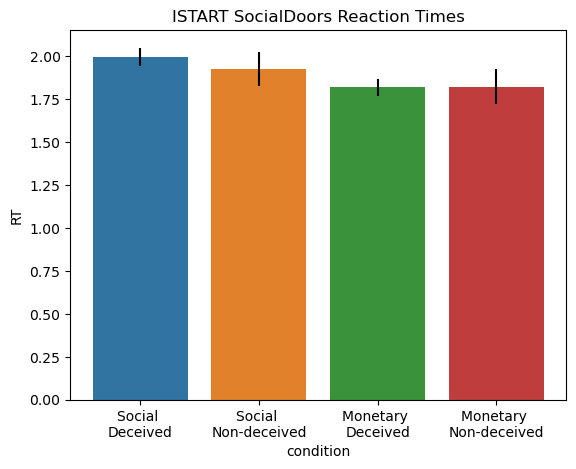

In [29]:
# Organize data
bar_df=pd.DataFrame(columns=['condition','RT','error'])
bar_df.loc[0,'condition']="Social \nDeceived"
bar_df.loc[1,'condition']="Social \nNon-deceived"
bar_df.loc[2,'condition']="Monetary \nDeceived"
bar_df.loc[3,'condition']="Monetary \nNon-deceived"
bar_df.loc[0,'RT']=np.nanmean(dec_df["socialRT"])
bar_df.loc[1,'RT']=np.nanmean(nondec_df["socialRT"])
bar_df.loc[2,'RT']=np.nanmean(dec_df["monetaryRT"])
bar_df.loc[3,'RT']=np.nanmean(nondec_df["monetaryRT"])
bar_df.loc[0,'error']=np.std(dec_df["socialRT"])/np.sqrt(len(dec_df["socialRT"]))
bar_df.loc[1,'error']=np.std(nondec_df["socialRT"])/np.sqrt(len(nondec_df["socialRT"]))
bar_df.loc[2,'error']=np.std(dec_df["monetaryRT"])/np.sqrt(len(dec_df["monetaryRT"]))
bar_df.loc[3,'error']=np.std(nondec_df["monetaryRT"])/np.sqrt(len(nondec_df["monetaryRT"]))

#bar_df.head()

# suppress warning output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# plot RTs
plt.figure()
g=sms.barplot(x='condition',y='RT',data=bar_df)
x_coords = [p.get_x() + 0.5*p.get_width() for p in g.patches]
y_coords = [p.get_height() for p in g.patches]
plt.errorbar(x=x_coords, y=y_coords, yerr=bar_df['error'],fmt='none',c='k')
g.set_title("ISTART SocialDoors Reaction Times")
plt.show()

In [30]:
# Run 2x2 ANOVA
import statsmodels.api as sm 
from statsmodels.formula.api import ols 

anova_df=pd.read_excel("RTs_anova.xlsx")
model = ols('RT ~ C(task) + C(deception) + C(task):C(deception)', data=anova_df).fit()
result=sm.stats.anova_lm(model,type=2)
print(result)

                        df    sum_sq   mean_sq         F    PR(>F)
C(task)                1.0  0.603756  0.603756  6.414899  0.013176
C(deception)           1.0  0.014571  0.014571  0.154817  0.694971
C(task):C(deception)   1.0  0.019560  0.019560  0.207828  0.649652
Residual              84.0  7.905891  0.094118       NaN       NaN


In [31]:
# For 2x2x2 ANOVA
# Read in usable subs
df=pd.DataFrame(data=open("newsubs.txt","r"),columns=['subs'])
df["social-win_RT"]=np.nan
df["social-loss_RT"]=np.nan
df["monetary-win_RT"]=np.nan
df["monetary-loss_RT"]=np.nan

for i in range(len(df)):
    df.loc[i,"subs"]=df.loc[i,"subs"].rstrip("\n")
    
    social_df=pd.read_csv('../../istart/social_reward_c/data/'+df.loc[i,"subs"]+'/sub-'+df.loc[i,"subs"]+'_task-socialdoors_run-1_events.tsv', sep="\t")
    doors_df=pd.read_csv('../../istart/social_reward_c/data/'+df.loc[i,"subs"]+'/sub-'+df.loc[i,"subs"]+'_task-doors_run-1_events.tsv', sep="\t")

    
    rt_following_social_win=[]
    rt_following_social_loss=[]
    rt_following_monetary_win=[]
    rt_following_monetary_loss=[]
    
    for index, row in social_df.iterrows():
        if row['trial_type']!='decision' and row['trial_type']!='decision-missed':
            if index+1 < len(social_df):
                next_row = social_df.loc[index+1]
                if row['trial_type']=='win':
                    rt_following_social_win.append(next_row['rt'])
                elif row['trial_type']=='loss':
                    rt_following_social_loss.append(next_row['rt'])
    for index, row in doors_df.iterrows():
        if row['trial_type']!='decision' and row['trial_type']!='decision-missed':
            if index+1 < len(doors_df):
                next_row = doors_df.loc[index+1]
                if row['trial_type']=='win':
                    rt_following_monetary_win.append(next_row['rt'])
                elif row['trial_type']=='loss':
                    rt_following_monetary_loss.append(next_row['rt'])
    
    df.loc[i,"social-win_RT"]=np.nanmean(rt_following_social_win)
    df.loc[i,"social-loss_RT"]=np.nanmean(rt_following_social_loss)
    df.loc[i,"monetary-win_RT"]=np.nanmean(rt_following_monetary_win)
    df.loc[i,"monetary-loss_RT"]=np.nanmean(rt_following_monetary_loss)
    
df.head()
#df.to_csv('RTs.csv',index=False)

,subs,social-win_RT,social-loss_RT,monetary-win_RT,monetary-loss_RT
0,1001,1.610880,1.597326,1.847933,1.735432
1,1003,2.213592,2.071983,1.956348,1.877109
2,1004,1.719312,1.691650,1.762396,1.850132
3,1006,2.086660,2.026327,1.864616,1.895640
4,1009,1.266685,1.222142,1.115775,1.153712


In [66]:
# Separate deceived and non-deceived subs
nondeceived=["1012","1019","1247","1251","1303","3116","3143","3176"]

nondec_df=df[df["subs"].isin(nondeceived)]
dec_df=df[~df["subs"].isin(nondeceived)]

#display(nondec_df)
#dec_df.head()

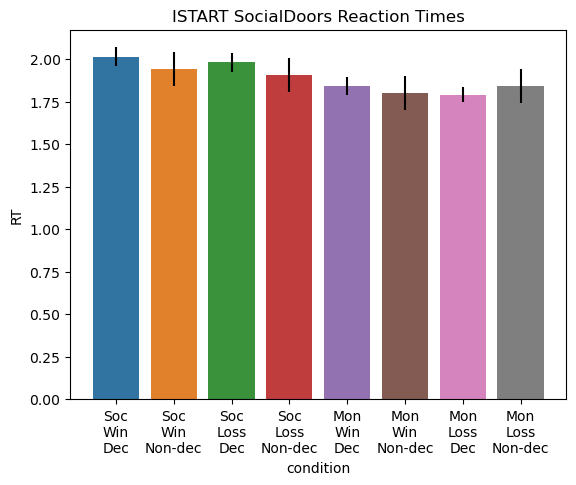

In [41]:
# Organize data
bar_df=pd.DataFrame(columns=['condition','RT','error'])
bar_df.loc[0,'condition']="Soc\nWin\nDec"
bar_df.loc[1,'condition']="Soc\nWin\nNon-dec"
bar_df.loc[2,'condition']="Soc\nLoss\nDec"
bar_df.loc[3,'condition']="Soc\nLoss\nNon-dec"
bar_df.loc[4,'condition']="Mon\nWin\nDec"
bar_df.loc[5,'condition']="Mon\nWin\nNon-dec"
bar_df.loc[6,'condition']="Mon\nLoss\nDec"
bar_df.loc[7,'condition']="Mon\nLoss\nNon-dec"

bar_df.loc[0,'RT']=np.nanmean(dec_df["social-win_RT"])
bar_df.loc[1,'RT']=np.nanmean(nondec_df["social-win_RT"])
bar_df.loc[2,'RT']=np.nanmean(dec_df["social-loss_RT"])
bar_df.loc[3,'RT']=np.nanmean(nondec_df["social-loss_RT"])
bar_df.loc[4,'RT']=np.nanmean(dec_df["monetary-win_RT"])
bar_df.loc[5,'RT']=np.nanmean(nondec_df["monetary-win_RT"])
bar_df.loc[6,'RT']=np.nanmean(dec_df["monetary-loss_RT"])
bar_df.loc[7,'RT']=np.nanmean(nondec_df["monetary-loss_RT"])


bar_df.loc[0,'error']=np.std(dec_df["social-win_RT"])/np.sqrt(len(dec_df["social-win_RT"]))
bar_df.loc[1,'error']=np.std(nondec_df["social-win_RT"])/np.sqrt(len(nondec_df["social-win_RT"]))
bar_df.loc[2,'error']=np.std(dec_df["social-loss_RT"])/np.sqrt(len(dec_df["social-loss_RT"]))
bar_df.loc[3,'error']=np.std(nondec_df["social-loss_RT"])/np.sqrt(len(nondec_df["social-loss_RT"]))
bar_df.loc[4,'error']=np.std(dec_df["monetary-win_RT"])/np.sqrt(len(dec_df["monetary-win_RT"]))
bar_df.loc[5,'error']=np.std(nondec_df["monetary-win_RT"])/np.sqrt(len(nondec_df["monetary-win_RT"]))
bar_df.loc[6,'error']=np.std(dec_df["monetary-loss_RT"])/np.sqrt(len(dec_df["monetary-loss_RT"]))
bar_df.loc[7,'error']=np.std(nondec_df["monetary-loss_RT"])/np.sqrt(len(nondec_df["monetary-loss_RT"]))

#bar_df.head()

# suppress warning output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# plot RTs
plt.figure()
g=sms.barplot(x='condition',y='RT',data=bar_df)#,palette="cubehelix")
x_coords = [p.get_x() + 0.5*p.get_width() for p in g.patches]
y_coords = [p.get_height() for p in g.patches]
plt.errorbar(x=x_coords, y=y_coords, yerr=bar_df['error'],fmt='none',c='k')
g.set_title("ISTART SocialDoors Reaction Times")
plt.show()

In [99]:
# Organize data for three-way ANOVA

anova_df=pd.DataFrame(columns=['subs','deception','task','trial_type','rt'])
with open("newsubs.txt","r") as file:
    subs_list = file.read().splitlines()
anova_df['subs'] = [sub for sub in subs_list for _ in range(4)]
anova_df['deception'] = ['deceived' if sub not in nondeceived else 'non-deceived' for sub in subs_list for _ in range (4)]
tasks = ['social', 'social', 'monetary', 'monetary']
anova_df['task'] = [task for _ in range(len(subs_list)) for task in tasks]
trial_type = ['win', 'loss', 'win', 'loss']
anova_df['trial_type'] = [trial for _ in range(len(subs_list)) for trial in trial_type]

for index, row in anova_df.iterrows():
    if row['task']=='social' and row['trial_type']=='win':
        anova_df.loc[index,'rt']=df.set_index('subs').at[row['subs'],'social-win_RT']
    elif row['task']=='social' and row['trial_type']=='loss':
        anova_df.loc[index,'rt']=df.set_index('subs').at[row['subs'],'social-loss_RT']
    if row['task']=='monetary' and row['trial_type']=='win':
        anova_df.loc[index,'rt']=df.set_index('subs').at[row['subs'],'monetary-win_RT']
    elif row['task']=='monetary' and row['trial_type']=='loss':
        anova_df.loc[index,'rt']=df.set_index('subs').at[row['subs'],'monetary-loss_RT']
anova_df['rt']=anova_df['rt'].astype(float)

anova_df

,subs,deception,task,trial_type,rt
0,1001,deceived,social,win,1.610880
1,1001,deceived,social,loss,1.597326
2,1001,deceived,monetary,win,1.847933
3,1001,deceived,monetary,loss,1.735432
4,1003,deceived,social,win,2.213592
...,...,...,...,...,...
171,3212,deceived,monetary,loss,1.465983
172,3220,deceived,social,win,2.206652
173,3220,deceived,social,loss,2.301463
174,3220,deceived,monetary,win,2.016241


In [100]:
# Run three-way ANOVA
import statsmodels.api as sm 
from statsmodels.formula.api import ols

model = ols("""rt ~ C(task) + C(deception) + C(trial_type) + 
            C(task):C(deception) + C(task):C(trial_type) + C(deception):C(trial_type) + 
            C(task):C(trial_type):C(deception)""", data=anova_df).fit()

result=sm.stats.anova_lm(model,type=2)
print(result)

                                       df     sum_sq   mean_sq          F  \
C(task)                               1.0   1.220651  1.220651  12.493400   
C(deception)                          1.0   0.032653  0.032653   0.334201   
C(trial_type)                         1.0   0.052610  0.052610   0.538467   
C(task):C(deception)                  1.0   0.039238  0.039238   0.401602   
C(task):C(trial_type)                 1.0   0.000039  0.000039   0.000402   
C(deception):C(trial_type)            1.0   0.014426  0.014426   0.147646   
C(task):C(trial_type):C(deception)    1.0   0.013726  0.013726   0.140490   
Residual                            168.0  16.414210  0.097704        NaN   

                                      PR(>F)  
C(task)                             0.000528  
C(deception)                        0.563970  
C(trial_type)                       0.464092  
C(task):C(deception)                0.527125  
C(task):C(trial_type)               0.984026  
C(deception):C(trial_typ